In [1]:
import GPy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from tqdm import tqdm
import time

# Set pandas view options
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# filter warnings messages from the notebook
import warnings
warnings.filterwarnings('ignore')

from monty.os import cd
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.svm import SVR

from camd.agent.base import RandomAgent, HypothesisAgent
from camd.analysis import AnalyzerBase
from camd.experiment import ATFSampler
from camd.campaigns.base import Campaign

In [2]:
featurized_data = pd.read_csv('../featurized_brgoch_data.csv', index_col=0)

seed_data, candidate_data = train_test_split(featurized_data, test_size=0.8, random_state=42)
# First we will drop all the candidate compositions if they 
# are already verified in seed data. 
seed_data_chemsys = list(seed_data.reduced_formula)
seed_data  = seed_data.append(candidate_data.loc[candidate_data.reduced_formula.isin(seed_data_chemsys)])
candidate_data = candidate_data[~candidate_data.reduced_formula.isin(seed_data_chemsys)]

print(len(seed_data), len(candidate_data))
print(len(seed_data)+len(candidate_data)==len(featurized_data))

3930 5018
True


# Analyzer 

In [3]:
class MultiAnalyzer(AnalyzerBase):
    def __init__(self, target_property, property_range):
        self.target_property = target_property 
        self.property_range = property_range
        
    def _filter_df_by_property_range(self, df):
        """
        Helper function to filter df by property range
        
        Args:
            df (DataFrame): dataframe to be filtered
        """
        return df.loc[(df[self.target_property] >= self.property_range[0]) & 
                      (df[self.target_property] <= self.property_range[1])]
    
    def analyze(self, new_experimental_results, seed_data):  #, agent=None):
        positive_hits = self._filter_df_by_property_range(new_experimental_results)

        new_exp_hypotheses = new_experimental_results.loc[new_experimental_results['expt_data'] == 1]
        new_discoveries = self._filter_df_by_property_range(new_exp_hypotheses)
        # Uncertainty?
        
        # total discovery up to (& including) the current iteration
        new_seed = seed_data.append(new_experimental_results)
        total_exp_hypotheses = new_seed.loc[new_seed['expt_data'] == 1]
        total_exp_discovery = self._filter_df_by_property_range(total_exp_hypotheses)
        
        summary = pd.DataFrame(
            {   "iteration tpr": [len(positive_hits)/ len(new_experimental_results)], 
                "iteration experiment tpr": [len(new_discoveries)/ len(new_exp_hypotheses)],
                "new_exp_discovery": [len(new_discoveries)], 
                "total_exp_discovery": [len(total_exp_discovery)]
                # "discoveries_per_cost": [len(new_discovery) / cost]
            }
        )
        return summary, new_seed

# Campaign

In [4]:
iterations = 20
N_query = 50

### 1. Random Agent

In [5]:
# Set up a folder for all the results file
os.system('rm -rf random')
os.system('mkdir -p random')

random_agent = RandomAgent(candidate_data=candidate_data, n_query=N_query)
random_experiment = ATFSampler(dataframe=featurized_data)
analyzer = MultiAnalyzer(target_property='bandgap', property_range=[1.6, 2.0])

with cd('random'):
    random_campaign = Campaign(candidate_data=candidate_data, seed_data=seed_data, 
                               agent=random_agent, experiment=random_experiment, 
                               analyzer=analyzer)

    random_campaign.auto_loop(n_iterations=iterations, initialize=True)

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing resu

In [6]:
random_history = pd.read_pickle('random/history.pickle')
random_history

,iteration tpr,iteration experiment tpr,new_exp_discovery,total_exp_discovery
0,0.02,0.000000,0,228
1,0.06,0.074074,2,230
2,0.04,0.064516,2,232
3,0.12,0.125000,3,235
4,0.04,0.034483,1,236
5,0.04,0.000000,0,236
6,0.04,0.032258,1,237
7,0.04,0.068966,2,239
8,0.04,0.037037,1,240
9,0.04,0.037037,1,241


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff64892cd68>,
      dtype=object)

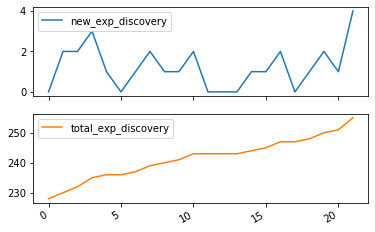

In [7]:
random_history[['new_exp_discovery', 'total_exp_discovery']].plot(subplots=True)

### 2. MultiAgent

#### 2.1 SVR

In [8]:
# Agent Design
# ----------------------------------------------------------------------
class MultiAgent(HypothesisAgent):
    def __init__(self, target_property='bandgap', ideal_property_value=1.8, 
                 candidate_data=None, seed_data=None, n_query=None, exp_query_frac=0.3, 
                 model=None, preprocessor=None,
                 cost_considered=False, uncertainty=True):
        self.target_property = target_property
        self.ideal_property_value = ideal_property_value
        self.candidate_data = candidate_data
        self.seed_data = seed_data
        self.n_query = n_query 
        self.exp_query_frac = exp_query_frac
        self.model = model
        self.preprocessor = preprocessor 
        self.cost_considered = cost_considered
        self.uncertainty = uncertainty
        super(MultiAgent).__init__()
        """
        Args:
            target_property          The candidate property agent is trying to predict on, 
                                     given feature space. i.e. bandgap.
            target_property_value    The ideal value of the target property.
            candidate_data           A pd.DataFrame of candidate search space learning.
            seed_data                A pd.DataFrame of training data for learning.
            N_query (int)            Number of hypotheses to generate. 
            exp_query_frac           The fraction of the quries that are experimental data
            model                    The machine learning model.
            preprocessor             The preprocessor that preprocess the feature space. 
                                     It can be a single step or a pipeline. 
            cost_considered          If True, hypotheses are generated based on both prediction value
                                     and the cost of generating such hypotheses. 
            uncertainty              If we want to use ML model such as GP, this arg should be True.                          
        """
    
    def get_features_from_df(self, df, add_fea=[]):
        """
        Helper function to get feature columns of a dataframe. 
        
        Args
            df           df where the features are extracted. 
            add_fea      additional features used in ML training      
            
        Returns
            feature_df   A dataframe that only contains the features used in ML. 
                         by default, this will be compositional features. 
        """
        magpie_columns = [column for column in df if column.startswith("MagpieData")]
        all_features = magpie_columns + add_fea
        feature_df = df[all_features] 
        return feature_df
       
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit the ML model
        X_train = self.get_features_from_df(seed_data, add_fea=['theory_data', 'expt_data']).values.tolist()
        y_train = np.array(seed_data[[self.target_property]])
        X_test = self.get_features_from_df(candidate_data, add_fea=['theory_data', 'expt_data']).values.tolist()
        if self.preprocessor:
            X_train = self.preprocessor.fit_transform(X_train)
            X_test = self.preprocessor.transform(X_test)
        
        # make predictions 
        if self.uncertainty:
            gp = GPy.models.GPRegression(X_train, y_train)
            gp.optimize('bfgs', max_iters=200)
            y_pred, unc = gp.predict(X_test)
            candidate_data['prediction'] = y_pred
            candidate_data['pred_unc'] = unc

            # Generate hypotheses
            candidate_data['dist_to_ideal'] = np.abs(self.ideal_property_value - candidate_data['prediction'])
            candidate_data = candidate_data.sort_values(by=['dist_to_ideal', 'pred_unc'])
            
        else: 
            self.model.fit(X_train, y_train)
            y_pred = self.model.predict(X_test)
            candidate_data['prediction'] = y_pred

            # Generate hypotheses
            candidate_data['dist_to_ideal'] = np.abs(self.ideal_property_value - candidate_data['prediction'])
            candidate_data = candidate_data.sort_values(by=['dist_to_ideal'])
        
        selected_hypotheses = pd.DataFrame(columns=candidate_data.columns)
        
        # First: select expt hypotheses that have enough structurally similar seed data  
        # that support their predicted label 
        seed_data_fea = self.get_features_from_df(seed_data)
        exp_candidates = candidate_data.loc[candidate_data.expt_data==1]
        exp_cands_fea = self.get_features_from_df(exp_candidates)

        for idx, cand_fea in exp_cands_fea.iterrows():
            if len(selected_hypotheses) < self.n_query * self.exp_query_frac:
                # find l2 norm of features between this candidate and all seed data 
                # and find the ones that are closest "structurally"
                expanded_cand_fea = pd.DataFrame([cand_fea]*len(seed_data_fea))
                normdiff = np.linalg.norm(expanded_cand_fea.values - seed_data_fea.values,  axis=1)
      
                # TODO: make threshold parameter
                # TODO: decide how many similar structure should be there 
                threshold = 200
                mask = normdiff <= threshold
                if len(normdiff[mask]) > 2: 
                    selected_hypotheses = selected_hypotheses.append(exp_candidates.loc[idx])
        
        
        # Genetate some theory hypotheses, which has good predictions and structurally similar
        # to the top experimental predicted candidates
        remained_exp_cands_fea = exp_cands_fea.drop(selected_hypotheses.index)
        
        theor_candidates = candidate_data.loc[candidate_data.theory_data==1]
        theor_cands_fea = self.get_features_from_df(theor_candidates)
        
        for idx, cand_fea in remained_exp_cands_fea.iterrows():
            if len(selected_hypotheses) < self.n_query:
                expanded_cand_fea = pd.DataFrame([cand_fea]*len(theor_cands_fea))
                normdiff = np.linalg.norm(expanded_cand_fea.values - theor_cands_fea.values,  axis=1)
                theor_candidates['normdiff'] = normdiff
                theor_candidates = theor_candidates.sort_values('normdiff')
                selected_hypotheses = selected_hypotheses.append(theor_candidates.head(4))

        return selected_hypotheses 

In [9]:
# Set up a folder for all the results file
os.system('rm -rf svr')
os.system('mkdir -p svr')

svr_agent = MultiAgent(target_property='bandgap', ideal_property_value=1.8, 
                   candidate_data=candidate_data, seed_data=seed_data, n_query=N_query,
                   model=SVR(C=10), preprocessor=preprocessing.StandardScaler()
                   )
svr_experiment = ATFSampler(dataframe=featurized_data)
svr_analyzer = MultiAnalyzer(target_property='bandgap', property_range=[1.6, 2.0])

with cd('svr'):
    random_campaign = Campaign(candidate_data=candidate_data, seed_data=seed_data, 
                               agent=svr_agent, experiment=svr_experiment, 
                               analyzer=svr_analyzer)
    random_campaign.auto_loop(n_iterations=iterations, initialize=True)


Campaign initialization state: Agent MultiAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent MultiAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent MultiAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent MultiAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent MultiAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing results
C

In [10]:
svr_history = pd.read_pickle('svr/history.pickle')
svr_history

,iteration tpr,iteration experiment tpr,new_exp_discovery,total_exp_discovery
0,0.039216,0.133333,2,230
1,0.098039,0.200000,3,233
2,0.137255,0.266667,4,237
3,0.058824,0.133333,2,239
4,0.019608,0.066667,1,240
5,0.117647,0.333333,5,245
6,0.078431,0.200000,3,248
7,0.117647,0.333333,5,253
8,0.019608,0.066667,1,254
9,0.078431,0.133333,2,256


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6493bd860>,
      dtype=object)

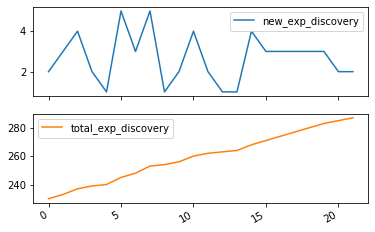

In [11]:
svr_history[['new_exp_discovery', 'total_exp_discovery']].plot(subplots=True)

#### 2.2 GP

In [12]:
# Set up a folder for all the results file
os.system('rm -rf GP')
os.system('mkdir -p GP')

GP_agent = MultiAgent(target_property='bandgap', ideal_property_value=1.8, 
                      candidate_data=candidate_data, seed_data=seed_data, n_query=N_query,
                      preprocessor=preprocessing.StandardScaler(), uncertainty=True,
                   )
GP_experiment = ATFSampler(dataframe=featurized_data)
GP_analyzer = MultiAnalyzer(target_property='bandgap', property_range=[1.6, 2.0])

with cd('GP'):
    random_campaign = Campaign(candidate_data=candidate_data, seed_data=seed_data, 
                               agent=GP_agent, experiment=GP_experiment, 
                               analyzer=GP_analyzer)
    random_campaign.auto_loop(n_iterations=iterations, initialize=True)

Campaign initialization state: Agent MultiAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent MultiAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent MultiAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent MultiAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent MultiAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing results
C

In [13]:
gp_history = pd.read_pickle('GP/history.pickle')
gp_history

,iteration tpr,iteration experiment tpr,new_exp_discovery,total_exp_discovery
0,0.039216,0.133333,2,230
1,0.098039,0.200000,3,233
2,0.137255,0.266667,4,237
3,0.058824,0.133333,2,239
4,0.019608,0.066667,1,240
5,0.117647,0.333333,5,245
6,0.078431,0.200000,3,248
7,0.117647,0.333333,5,253
8,0.019608,0.066667,1,254
9,0.078431,0.133333,2,256


#### Side by Side Analysis

* Total budget is 1000. (300 is  experimental allocation, rest is theory allocation)

* We only acquired 89 good experimental data. ~29% success rate 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3f821a3c8>,
      dtype=object)

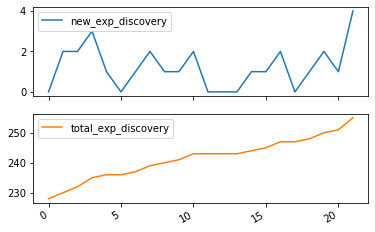

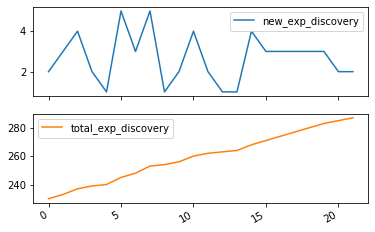

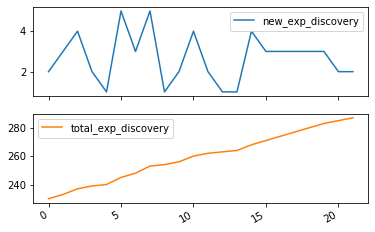

In [14]:
random_history[['new_exp_discovery', 'total_exp_discovery']].plot(subplots=True)
svr_history[['new_exp_discovery', 'total_exp_discovery']].plot(subplots=True)
gp_history[['new_exp_discovery', 'total_exp_discovery']].plot(subplots=True)

In [15]:
new_exp_discoveries = pd.DataFrame({'random_new_discovery': np.array(random_history['new_exp_discovery']),
                                'svr_new_discovery': np.array(svr_history['new_exp_discovery']),
                                'gp_new_discovery': np.array(gp_history['new_exp_discovery'])  
})
new_exp_discoveries

,random_new_discovery,svr_new_discovery,gp_new_discovery
0,0,2,2
1,2,3,3
2,2,4,4
3,3,2,2
4,1,1,1
5,0,5,5
6,1,3,3
7,2,5,5
8,1,1,1
9,1,2,2


In [16]:
total_exp_discoveries = pd.DataFrame({'random_tot_discovery': np.array(random_history['total_exp_discovery']),
                                'svr_tot_discovery': np.array(svr_history['total_exp_discovery']),
                                'gp_tot_discovery': np.array(gp_history['total_exp_discovery'])  
})

total_exp_discoveries-228

,random_tot_discovery,svr_tot_discovery,gp_tot_discovery
0,0,2,2
1,2,5,5
2,4,9,9
3,7,11,11
4,8,12,12
5,8,17,17
6,9,20,20
7,11,25,25
8,12,26,26
9,13,28,28
